# **Classificação de imagens** 

Nos deparamos com flores em inúmeras ocasiões. E, por vezes, nos deparamos com flores ainda desconhecidas e gostaríamos de saber mais sobre elas. E se o computador ou o celular pudesse classificar as flores e suprir nossa curiosidade? Esse é o desafio deste artigo.

**Objetivo:** Utilizar Deep Learning para classificar imagens de flores em 5 categorias.

Para isso, foi utilizado o dataset tf_flowers disponível no pacote tensorflow-datasets. 


O diretório pussui 5 classes:
* Margarida
* Dente de leão
* Rosa
* Girassol
* Tulipa

In [1]:
# Instalando a biblioteca externa para modelos de deep learning 
!pip install tensorflow

In [2]:
# Importando as bibliotecas
import tensorflow as tf # Para modelos de deep learning
import numpy as np # Para aplicar funções matemáticas em matrizes
import matplotlib.pyplot as plt # Para visualização de dados

import tensorflow_datasets as tfds # Para obter o dataset

In [3]:
# Carregando o dataset
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [4]:
# Obtendo os nomes e o número de classes
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print(f'O dataset possui {n_classes} classes, sendo elas: \n{class_names}')

O dataset possui 5 classes, sendo elas: 
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


Aqui, 80% das imagens serão usadas para treinamento e 20% para teste.

In [5]:
# Separando os conjuntos de treino e de teste
(train_set, test_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [6]:
# Separando as features e as labels do conjunto de teste
# Para facilitar a plotagem gráfica ao final
images_test=[]
labels_test=[]

for image,label in test_set:
    images_test.append(image)
    labels_test.append(label.numpy())

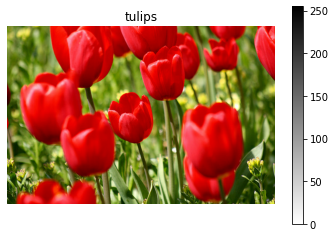

In [7]:
# Visualizando uma imagem do conjunto de treino
for image in train_set.take(1):
    plt.figure()
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.title(class_names[image[1]])
    plt.axis("off")
    plt.colorbar()
    break

In [8]:
# Os formatos das imagens do dataset Flowers variam
# Elas serão redimensionadas em um formato único
for i, image in enumerate(train_set.take(5)):
    print('Formato da imagem {}: {} label: {}'.format(i+1, image[0].shape, image[1]))

Formato da imagem 1: (333, 500, 3) label: 2
Formato da imagem 2: (212, 320, 3) label: 3
Formato da imagem 3: (240, 320, 3) label: 3
Formato da imagem 4: (240, 320, 3) label: 4
Formato da imagem 5: (317, 500, 3) label: 3


In [9]:
# Declarando algumas variáveis
batch_size = 32
img_height = 180
img_width = 180

# Para melhorar a performance de carregamento dos dados
AUTOTUNE = tf.data.AUTOTUNE

# Camada de normalização
rescaling_layer = tf.keras.layers.Rescaling(1./255)

# Definindo uma função para configurar os datasets de treino e de teste
def create_dataset(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)

    # Redimensionando as imagens
    ds = ds.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

    # Normalização, padronizando os valores de pixel na faixa de [0 ,1]
    ds = ds.map(lambda x, y: (rescaling_layer(x), y))
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(AUTOTUNE)
    return ds

# Aplicando a função para configurar os conjuntos de treino e de teste
train_set = create_dataset(train_set, shuffle=True)
test_set = create_dataset(test_set)

O canal RGB possui valores de 0 a 255. Para a rede neural, esses valores foram reduzidos e padronizados pela normalização dos mesmos (ou seja, para estarem na faixa de 0 a 1) na própria função acima.

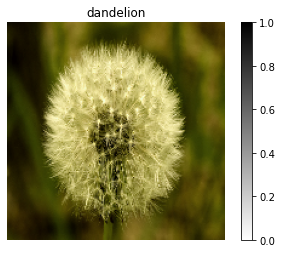

In [44]:
# Visualizando uma imagem do conjunto de treino após configurar o dataset
for image, label in train_set:
    plt.figure()
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.title(class_names[label[0]])
    plt.axis("off")
    plt.colorbar()
    break

&nbsp;
### Visualização dos dados
---

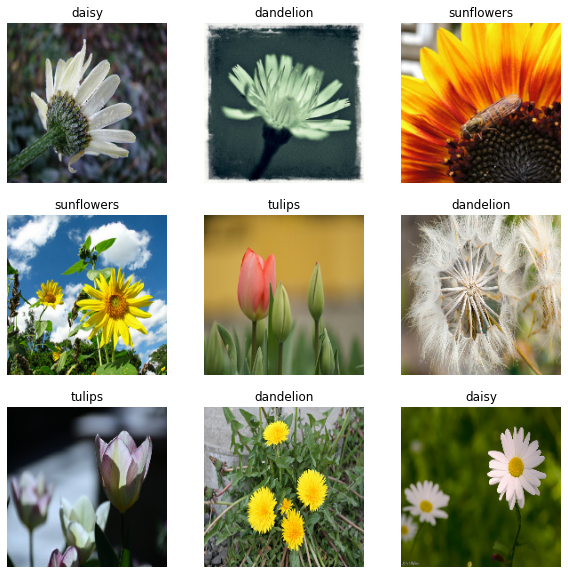

In [11]:
plt.figure(figsize=(10, 10))
i = 0
for image, label in train_set.take(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(image[i], cmap=plt.cm.binary)
    plt.title(class_names[label[i]])
    plt.axis("off")
    i += 1

&nbsp;
### Criando o modelo de Deep Learning
---

In [12]:

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(180, 180, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [13]:
model = tf.keras.Sequential([
                              data_augmentation,

                              tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              
                              tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
                              tf.keras.layers.MaxPooling2D(),

                              tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Flatten(),
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(n_classes)
])

In [14]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Arquitetura do modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

O modelo Sequencial possuis três sessões de convolução seguida por agrupamento máximo. Há também uma camada densa com 128 unidades ativada pela função de ReLU.  

&nbsp;
### Treinando o modelo
---

In [16]:
from keras.callbacks import ModelCheckpoint 

# Para salvar o melhor modelo
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', verbose=1, save_best_only=True)

In [17]:
history = model.fit(train_set, validation_data=test_set, epochs=20, callbacks=[checkpointer])

Epoch 1/20
92/92 [==============================] - ETA: 0s - loss: 1.2475 - accuracy: 0.4775
Epoch 1: val_loss improved from inf to 1.03220, saving model to weights.best.model.hdf5
92/92 [==============================] - 86s 921ms/step - loss: 1.2475 - accuracy: 0.4775 - val_loss: 1.0322 - val_accuracy: 0.6035
Epoch 2/20
92/92 [==============================] - ETA: 0s - loss: 1.0108 - accuracy: 0.6124
Epoch 2: val_loss improved from 1.03220 to 0.91155, saving model to weights.best.model.hdf5
92/92 [==============================] - 95s 1s/step - loss: 1.0108 - accuracy: 0.6124 - val_loss: 0.9115 - val_accuracy: 0.6362
Epoch 3/20
92/92 [==============================] - ETA: 0s - loss: 0.9029 - accuracy: 0.6485
Epoch 3: val_loss improved from 0.91155 to 0.86652, saving model to weights.best.model.hdf5
92/92 [==============================] - 91s 991ms/step - loss: 0.9029 - accuracy: 0.6485 - val_loss: 0.8665 - val_accuracy: 0.6499
Epoch 4/20
92/92 [==============================] - E

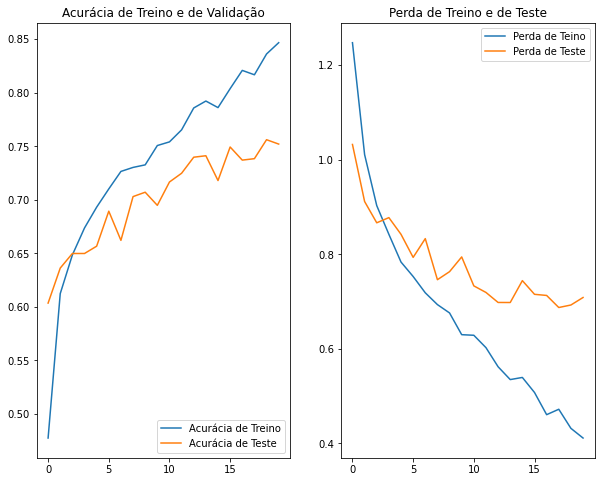

In [18]:
# Plotando o histórico das acurácias de treino e de teste durante o treinamento do modelo

epochs_range = range(20)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Teste')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e de Validação')


# Plotando o histórico das acurácias de treino e de teste durante o treinamento do modelo
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Teino')
plt.plot(epochs_range, val_loss, label='Perda de Teste')
plt.legend(loc='upper right')
plt.title('Perda de Treino e de Teste')
plt.show()

In [19]:
# Carrega o melhor modelo treinado
model = tf.keras.models.load_model('weights.best.model.hdf5')

In [28]:
loss, acc = model.evaluate(train_set, verbose=2)
print("A acurácia do modelo com os dados de treinamento é: {:.2f}%".format(100 * acc))

92/92 - 14s - loss: 0.3869 - accuracy: 0.8559 - 14s/epoch - 147ms/step
A acurácia do modelo com os dados de treinamento é: 85.59%


In [21]:
loss, acc = model.evaluate(test_set, verbose=2)
print("A acurácia do modelo com os dados de teste é: {:.2f}%".format(100 * acc))

23/23 - 3s - loss: 0.6873 - accuracy: 0.7384 - 3s/epoch - 140ms/step
A acurácia do modelo com os dados de teste é: 73.84%


&nbsp;
### Utilizando modelo treinado para prever dados
---

In [22]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [23]:
predictions = probability_model.predict(test_set)

23/23 [==============================] - 4s 142ms/step


In [24]:
n=500

In [25]:
score = predictions[n]
class_number = np.argmax(score)
class_names[class_number]

'daisy'

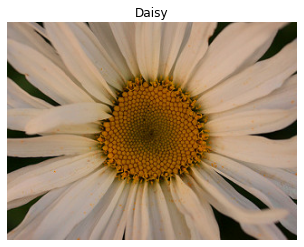

In [26]:
plt.imshow(images_test[n], cmap=plt.cm.binary)
class_number = labels_test[n]
plt.title(class_names[class_number].title())
plt.axis("off");

&nbsp;
### Visualização gráfica das predições
---

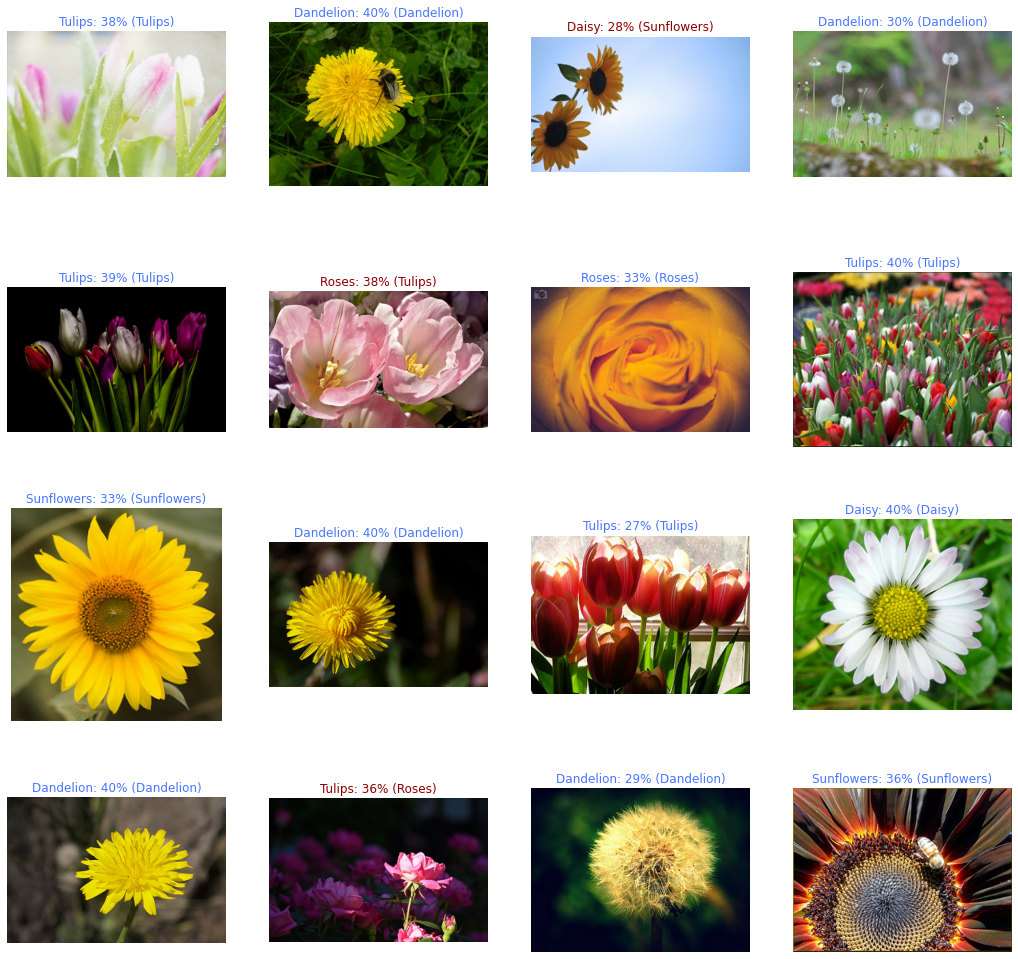

In [29]:
plt.figure(figsize=(18, 18))

n=0

for i in range(16,32):
    plt.subplot(4, 4, n+1)
    n=n+1
    
    predicted_label = np.argmax(tf.nn.softmax(predictions[i])) # Retorna a classe com maior probabilidade
    name_predicted_label = (class_names[predicted_label]) # Retorna o nome da classe com maior probabilidade
    probability = np.max(tf.nn.softmax(predictions[i])) # Retorna o valor da maior probabilidade  
    
    plt.imshow(images_test[i].numpy().astype("uint8")) # Plota a imagem predita do conjunto de teste 
    true_label = class_names[labels_test[i]] # Retorna o real nome da classe da imagem
    
    plt.title(f"{name_predicted_label.title()}: {probability*100:2.0f}% ({true_label.title()})",
                 color=("#4876ff" if name_predicted_label == true_label else "darkred"))
    # Os títulos em azul estão corretos e em vermelho estão errado
    plt.axis("off")